# Import librairies

In [131]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [132]:
data = pd.read_csv('df_rio_interpolado.csv')

In [133]:
data.head(5)

,TEMP
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42


In [134]:
scaler = MinMaxScaler()

In [135]:
# Ajustar o scaler e transformar os dados na coluna TEMP
scaled_data = scaler.fit_transform(data[['TEMP']])

In [136]:
# Salvar o scaler para uso posterior (por exemplo, para reverter a padronização)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [137]:
# Verificar os dados padronizados
print(data.head())

    TEMP
0  27.73
1  27.97
2  25.70
3  26.49
4  22.42


## Train test split

In [138]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [139]:
# Total de dados
total_data_len = len(scaled_data)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


564
394
84


In [140]:
# Criando conjuntos de treinamento
train_data = scaled_data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

334
334
394


In [141]:
# Criando o conjunto de validação
valid_data = scaled_data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

24
24
84


In [142]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = scaled_data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = scaled_data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

86
86
146


In [143]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'y_valid length: {len(y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 334
Y_train length: 334
X_valid length: 24
y_valid length: 24
X_test length: 86
Y_test length: 86


# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [144]:
epochs_mlp = 30
batch = 32
lr = 0.001

### Implementacao e ajuste do Modelo MLP

In [145]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp.summary()

In [146]:
history_mlp = model_mlp.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

Epoch 1/30
11/11 - 2s - 177ms/step - loss: 0.0573 - val_loss: 0.0249
Epoch 2/30
11/11 - 0s - 7ms/step - loss: 0.0251 - val_loss: 0.0174
Epoch 3/30
11/11 - 0s - 7ms/step - loss: 0.0197 - val_loss: 0.0129
Epoch 4/30
11/11 - 0s - 6ms/step - loss: 0.0163 - val_loss: 0.0110
Epoch 5/30
11/11 - 0s - 8ms/step - loss: 0.0143 - val_loss: 0.0107
Epoch 6/30
11/11 - 0s - 13ms/step - loss: 0.0130 - val_loss: 0.0098
Epoch 7/30
11/11 - 0s - 11ms/step - loss: 0.0121 - val_loss: 0.0092
Epoch 8/30
11/11 - 0s - 8ms/step - loss: 0.0114 - val_loss: 0.0086
Epoch 9/30
11/11 - 0s - 8ms/step - loss: 0.0110 - val_loss: 0.0083
Epoch 10/30
11/11 - 0s - 14ms/step - loss: 0.0106 - val_loss: 0.0080
Epoch 11/30
11/11 - 0s - 20ms/step - loss: 0.0103 - val_loss: 0.0079
Epoch 12/30
11/11 - 0s - 16ms/step - loss: 0.0101 - val_loss: 0.0076
Epoch 13/30
11/11 - 0s - 28ms/step - loss: 0.0099 - val_loss: 0.0074
Epoch 14/30
11/11 - 0s - 14ms/step - loss: 0.0096 - val_loss: 0.0071
Epoch 15/30
11/11 - 0s - 8ms/step - loss: 0.0094

### Implementacao e Ajuste do Modelo MLP com regularização

In [147]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1], 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(32, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp_reg.summary()

In [148]:
history_mlp_reg = model_mlp_reg.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

Epoch 1/30
11/11 - 5s - 423ms/step - loss: 1.0902 - val_loss: 0.9851
Epoch 2/30
11/11 - 0s - 9ms/step - loss: 0.9438 - val_loss: 0.8867
Epoch 3/30
11/11 - 0s - 8ms/step - loss: 0.8523 - val_loss: 0.8017
Epoch 4/30
11/11 - 0s - 10ms/step - loss: 0.7660 - val_loss: 0.7187
Epoch 5/30
11/11 - 0s - 8ms/step - loss: 0.6881 - val_loss: 0.6448
Epoch 6/30
11/11 - 0s - 7ms/step - loss: 0.6174 - val_loss: 0.5784
Epoch 7/30
11/11 - 0s - 7ms/step - loss: 0.5532 - val_loss: 0.5179
Epoch 8/30
11/11 - 0s - 8ms/step - loss: 0.4955 - val_loss: 0.4634
Epoch 9/30
11/11 - 0s - 41ms/step - loss: 0.4436 - val_loss: 0.4148
Epoch 10/30
11/11 - 1s - 52ms/step - loss: 0.3972 - val_loss: 0.3713
Epoch 11/30
11/11 - 0s - 41ms/step - loss: 0.3555 - val_loss: 0.3323
Epoch 12/30
11/11 - 0s - 17ms/step - loss: 0.3184 - val_loss: 0.2975
Epoch 13/30
11/11 - 0s - 20ms/step - loss: 0.2853 - val_loss: 0.2664
Epoch 14/30
11/11 - 0s - 28ms/step - loss: 0.2559 - val_loss: 0.2389
Epoch 15/30
11/11 - 0s - 8ms/step - loss: 0.2297

### Implementacao e ajuste do modelo MLP com Dropout

In [149]:
model_mlp_dropout = Sequential()
model_mlp_dropout.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp_dropout.add(Dropout(0.3))  
model_mlp_dropout.add(Dense(32, activation='relu'))
model_mlp_dropout.add(Dropout(0.3))  
model_mlp_dropout.add(Dense(1))  
model_mlp_dropout.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp_dropout.summary()



In [150]:
history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

Epoch 1/30
11/11 - 2s - 207ms/step - loss: 0.2026 - val_loss: 0.0414
Epoch 2/30
11/11 - 0s - 18ms/step - loss: 0.1064 - val_loss: 0.0222
Epoch 3/30
11/11 - 0s - 17ms/step - loss: 0.0706 - val_loss: 0.0159
Epoch 4/30
11/11 - 0s - 18ms/step - loss: 0.0555 - val_loss: 0.0148
Epoch 5/30
11/11 - 0s - 30ms/step - loss: 0.0417 - val_loss: 0.0163
Epoch 6/30
11/11 - 0s - 15ms/step - loss: 0.0395 - val_loss: 0.0116
Epoch 7/30
11/11 - 0s - 30ms/step - loss: 0.0399 - val_loss: 0.0135
Epoch 8/30
11/11 - 0s - 8ms/step - loss: 0.0352 - val_loss: 0.0135
Epoch 9/30
11/11 - 0s - 9ms/step - loss: 0.0340 - val_loss: 0.0142
Epoch 10/30
11/11 - 0s - 10ms/step - loss: 0.0322 - val_loss: 0.0146
Epoch 11/30
11/11 - 0s - 14ms/step - loss: 0.0325 - val_loss: 0.0119
Epoch 12/30
11/11 - 0s - 10ms/step - loss: 0.0310 - val_loss: 0.0133
Epoch 13/30
11/11 - 0s - 7ms/step - loss: 0.0330 - val_loss: 0.0159
Epoch 14/30
11/11 - 0s - 9ms/step - loss: 0.0265 - val_loss: 0.0119
Epoch 15/30
11/11 - 0s - 12ms/step - loss: 0.0

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [151]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))  # Taxa de dropout de 20%
model_mlp_reg_drop.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [152]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train, 
                                              Y_train, 
                                              validation_data=(X_valid, Y_valid), 
                                              epochs=epochs_mlp, 
                                              batch_size=32, 
                                              verbose=1)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.3491 - mae: 0.3380 - val_loss: 0.1758 - val_mae: 0.1039
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2181 - mae: 0.1926 - val_loss: 0.1591 - val_mae: 0.0801
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1979 - mae: 0.1818 - val_loss: 0.1535 - val_mae: 0.0894
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1806 - mae: 0.1611 - val_loss: 0.1522 - val_mae: 0.1106
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1674 - mae: 0.1498 - val_loss: 0.1419 - val_mae: 0.0986
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1574 - mae: 0.1345 - val_loss: 0.1335 - val_mae: 0.0881
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1486 - mae: 0.1287 - val_loss: 0.1388 - val_mae: 0.1235
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1409 - mae: 0.1204 - val_loss: 0.1229 - val_mae: 0.0854
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1356 - mae:

## Comparando os 4 modelos

In [153]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)
    
    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100
    accuracy = 100 - mape  # Interpretação da acurácia como "100 - MAPE"
    
    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"Acurácia: {accuracy:.2f}%")
    
    return mae, mse, rmse, mape, accuracy

# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard, acc_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg, acc_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout, acc_dropout = evaluate_model(model_mlp_dropout, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop, acc_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

# Comparação dos resultados (opcional)
print("\nComparação de resultados:")
print(f"Modelo Padrão - MAE: {mae_standard:.4f}, RMSE: {rmse_standard:.4f}, MAPE: {mape_standard:.4f}%, Acurácia: {acc_standard:.2f}%")
print(f"Modelo com Regularização - MAE: {mae_reg:.4f}, RMSE: {rmse_reg:.4f}, MAPE: {mape_reg:.4f}%, Acurácia: {acc_reg:.2f}%")
print(f"Modelo com Dropout - MAE: {mae_dropout:.4f}, RMSE: {rmse_dropout:.4f}, MAPE: {mape_dropout:.4f}%, Acurácia: {acc_dropout:.2f}%")
print(f"Modelo com Regularização e Dropout - MAE: {mae_reg_drop:.4f}, RMSE: {rmse_reg_drop:.4f}, MAPE: {mape_reg_drop:.4f}%, Acurácia: {acc_reg_drop:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Modelo Padrão:
MAE: 0.0802
MSE: 0.0106
RMSE: 0.1029
MAPE: 17.9239%
Acurácia: 82.08%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Modelo com Regularização:
MAE: 0.0755
MSE: 0.0091
RMSE: 0.0952
MAPE: 17.6140%
Acurácia: 82.39%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Modelo com Dropout:
MAE: 0.1060
MSE: 0.0170
RMSE: 0.1303
MAPE: 21.9824%
Acurácia: 78.02%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Modelo com Regularização e Dropout:
MAE: 0.1065
MSE: 0.0164
RMSE: 0.1281
MAPE: 23.3174%
Acurácia: 76.68%

Comparação de resultados:
Modelo Padrão - MAE: 0.0802, RMSE: 0.1029, MAPE: 17.9239%, Acurácia: 82.08%
Modelo com Regularização - MAE: 0.0755, RMSE: 0.0952, MAPE: 17.6140%, Acurácia: 82.39%
Modelo com Dropout - MAE: 0.1060, RMSE: 0.1303, MAPE: 21.9824%, Acurácia: 78.02%
Modelo com Regularização e Dropout - MAE: 0.1065, RMSE: 0.1281, MAPE: 23.3174%, Acurácia: 76.68%


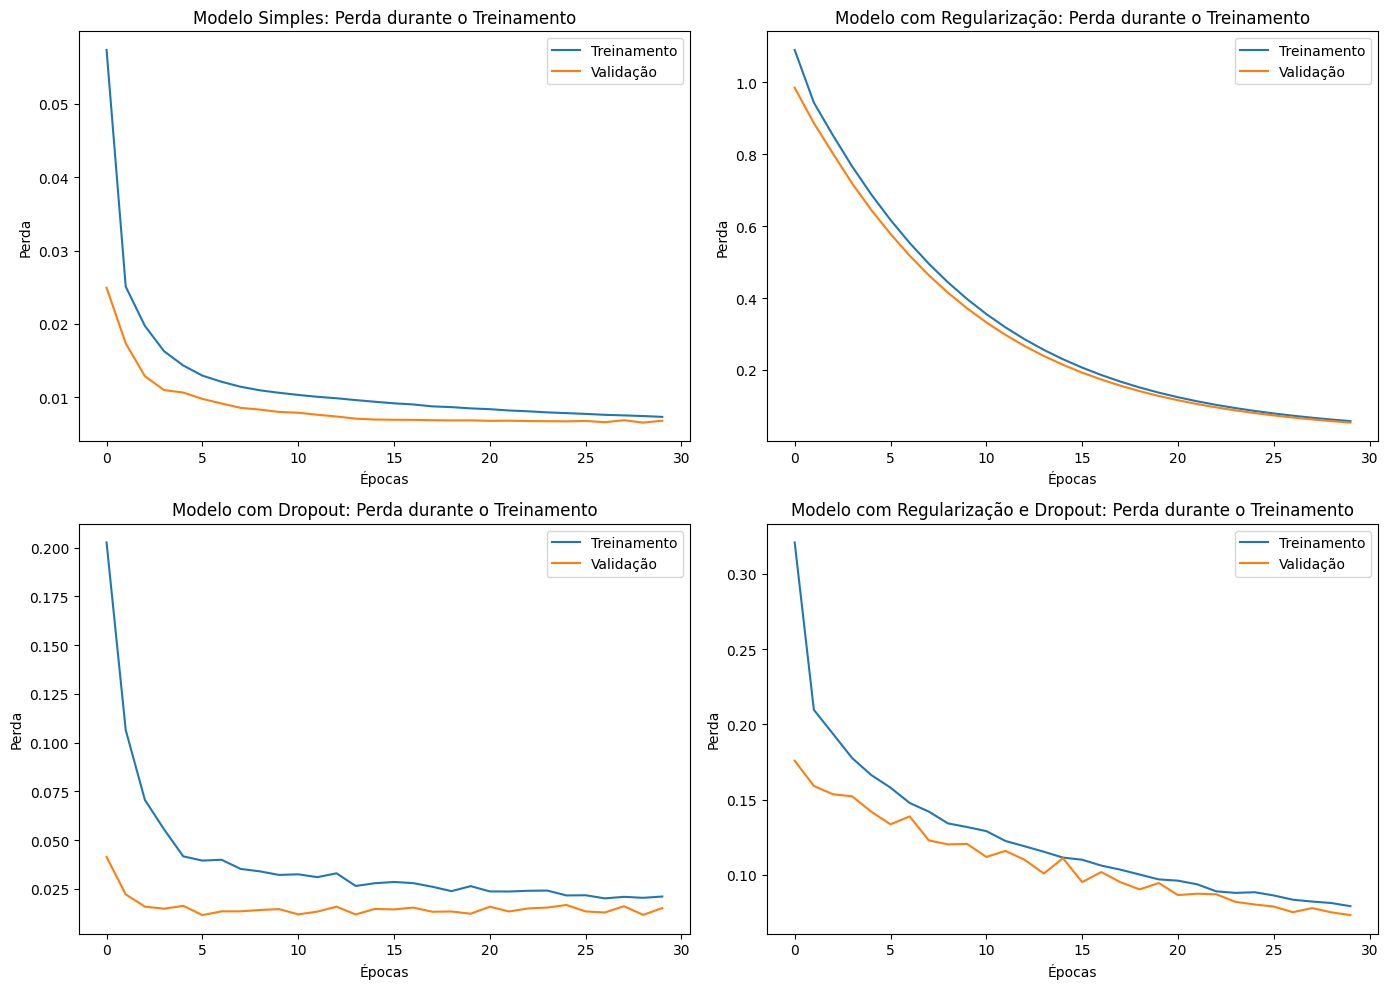

In [154]:
# Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_mlp.history['loss'], label='Treinamento')
plt.plot(history_mlp.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_mlp_reg.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_mlp_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_mlp_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [155]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_dropout.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


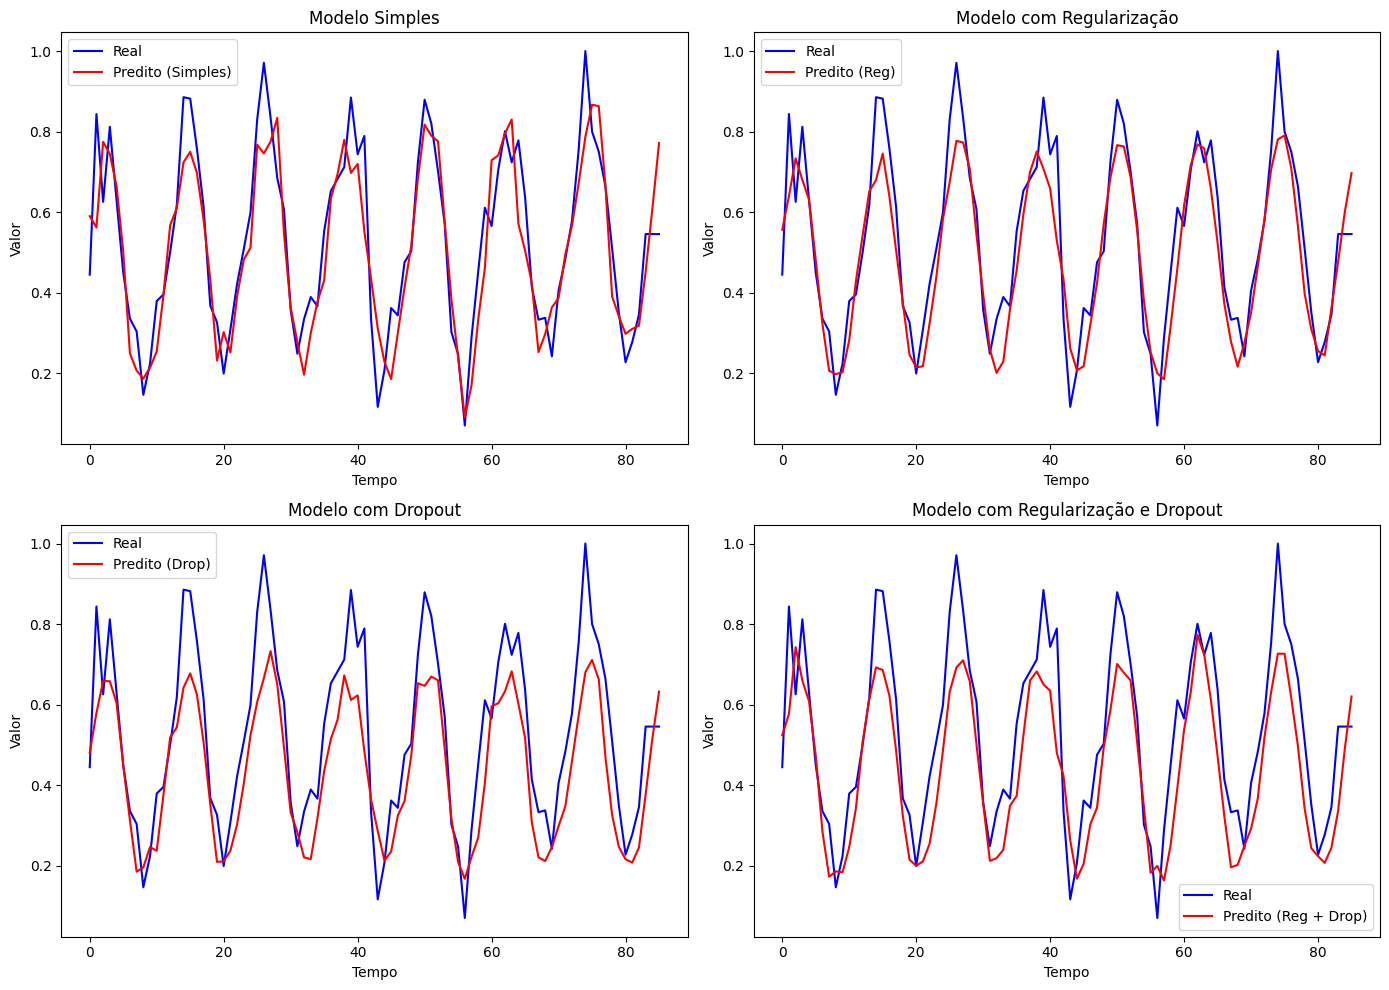

In [156]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

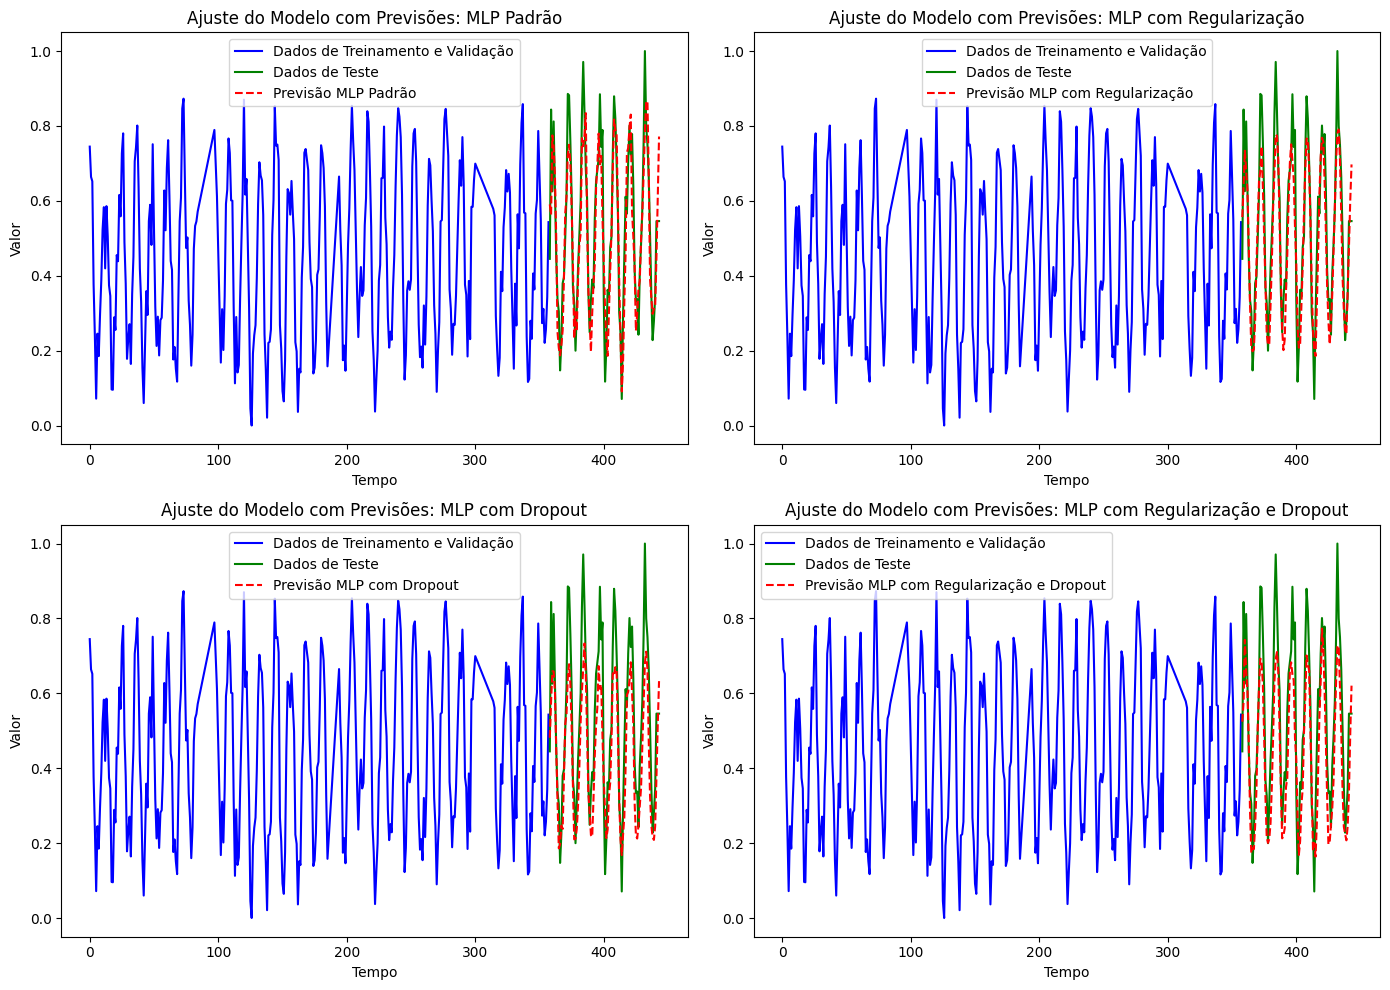

In [157]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Pre-processamento dos Dados

In [158]:
#Hiperparametros
epochs_cnn = 30
batch = 32
lr = 0.001
#adam = optimizers.Adam(lr)


In [159]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (334, 60, 1)
Validation set shape (24, 60, 1)
Test set shape (86, 60, 1)


## Implementando e Ajustando Modelo CNN

In [160]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn.summary()

In [161]:
history_cnn = model_cnn.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs_cnn, 
                            verbose=2)

Epoch 1/30
11/11 - 3s - 239ms/step - loss: 0.0571 - val_loss: 0.0146
Epoch 2/30
11/11 - 0s - 31ms/step - loss: 0.0154 - val_loss: 0.0107
Epoch 3/30
11/11 - 0s - 18ms/step - loss: 0.0151 - val_loss: 0.0106
Epoch 4/30
11/11 - 0s - 13ms/step - loss: 0.0146 - val_loss: 0.0113
Epoch 5/30
11/11 - 0s - 16ms/step - loss: 0.0138 - val_loss: 0.0097
Epoch 6/30
11/11 - 0s - 15ms/step - loss: 0.0132 - val_loss: 0.0091
Epoch 7/30
11/11 - 0s - 17ms/step - loss: 0.0127 - val_loss: 0.0084
Epoch 8/30
11/11 - 0s - 14ms/step - loss: 0.0124 - val_loss: 0.0080
Epoch 9/30
11/11 - 0s - 14ms/step - loss: 0.0121 - val_loss: 0.0081
Epoch 10/30
11/11 - 0s - 17ms/step - loss: 0.0117 - val_loss: 0.0084
Epoch 11/30
11/11 - 0s - 12ms/step - loss: 0.0114 - val_loss: 0.0086
Epoch 12/30
11/11 - 0s - 18ms/step - loss: 0.0110 - val_loss: 0.0087
Epoch 13/30
11/11 - 0s - 14ms/step - loss: 0.0107 - val_loss: 0.0086
Epoch 14/30
11/11 - 0s - 12ms/step - loss: 0.0103 - val_loss: 0.0084
Epoch 15/30
11/11 - 0s - 14ms/step - loss:

## Implementando e Ajustando Modelo CNN com Regularização L2

In [162]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn_reg.summary()


In [163]:
history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs_cnn, 
                            verbose=2)

Epoch 1/30
11/11 - 3s - 254ms/step - loss: 0.9329 - val_loss: 0.6849
Epoch 2/30
11/11 - 0s - 36ms/step - loss: 0.5766 - val_loss: 0.4383
Epoch 3/30
11/11 - 0s - 10ms/step - loss: 0.3677 - val_loss: 0.2844
Epoch 4/30
11/11 - 0s - 14ms/step - loss: 0.2488 - val_loss: 0.2029
Epoch 5/30
11/11 - 0s - 16ms/step - loss: 0.1809 - val_loss: 0.1507
Epoch 6/30
11/11 - 0s - 12ms/step - loss: 0.1408 - val_loss: 0.1219
Epoch 7/30
11/11 - 0s - 15ms/step - loss: 0.1157 - val_loss: 0.1015
Epoch 8/30
11/11 - 0s - 32ms/step - loss: 0.0982 - val_loss: 0.0865
Epoch 9/30
11/11 - 0s - 31ms/step - loss: 0.0850 - val_loss: 0.0755
Epoch 10/30
11/11 - 0s - 18ms/step - loss: 0.0746 - val_loss: 0.0658
Epoch 11/30
11/11 - 0s - 33ms/step - loss: 0.0661 - val_loss: 0.0582
Epoch 12/30
11/11 - 0s - 44ms/step - loss: 0.0593 - val_loss: 0.0521
Epoch 13/30
11/11 - 0s - 35ms/step - loss: 0.0536 - val_loss: 0.0468
Epoch 14/30
11/11 - 1s - 50ms/step - loss: 0.0490 - val_loss: 0.0425
Epoch 15/30
11/11 - 0s - 30ms/step - loss:

## Implementando e Ajustando Modelo CNN com Dropout

In [164]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.3))  
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.3))  
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn_drop.summary()

In [165]:
history_cnn_drop = model_cnn_drop.fit(X_train_series, Y_train, 
                                       validation_data=(X_valid_series, Y_valid), 
                                       epochs=epochs_cnn, 
                                       verbose=2)


Epoch 1/30
11/11 - 4s - 334ms/step - loss: 0.1321 - val_loss: 0.0356
Epoch 2/30
11/11 - 0s - 19ms/step - loss: 0.0454 - val_loss: 0.0196
Epoch 3/30
11/11 - 0s - 28ms/step - loss: 0.0302 - val_loss: 0.0114
Epoch 4/30
11/11 - 0s - 38ms/step - loss: 0.0259 - val_loss: 0.0096
Epoch 5/30
11/11 - 0s - 18ms/step - loss: 0.0254 - val_loss: 0.0096
Epoch 6/30
11/11 - 0s - 35ms/step - loss: 0.0233 - val_loss: 0.0100
Epoch 7/30
11/11 - 1s - 61ms/step - loss: 0.0211 - val_loss: 0.0109
Epoch 8/30
11/11 - 0s - 28ms/step - loss: 0.0232 - val_loss: 0.0101
Epoch 9/30
11/11 - 0s - 29ms/step - loss: 0.0214 - val_loss: 0.0098
Epoch 10/30
11/11 - 0s - 29ms/step - loss: 0.0228 - val_loss: 0.0088
Epoch 11/30
11/11 - 1s - 51ms/step - loss: 0.0216 - val_loss: 0.0088
Epoch 12/30
11/11 - 0s - 23ms/step - loss: 0.0195 - val_loss: 0.0087
Epoch 13/30
11/11 - 0s - 16ms/step - loss: 0.0227 - val_loss: 0.0084
Epoch 14/30
11/11 - 0s - 15ms/step - loss: 0.0213 - val_loss: 0.0089
Epoch 15/30
11/11 - 0s - 13ms/step - loss:

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [166]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn_reg_drop.summary()

In [167]:
history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series, Y_train, 
                                             validation_data=(X_valid_series, Y_valid), 
                                             epochs=epochs_cnn, 
                                             verbose=2)


Epoch 1/30
11/11 - 3s - 303ms/step - loss: 0.9255 - val_loss: 0.6758
Epoch 2/30
11/11 - 0s - 34ms/step - loss: 0.5641 - val_loss: 0.4236
Epoch 3/30
11/11 - 0s - 10ms/step - loss: 0.3682 - val_loss: 0.2786
Epoch 4/30
11/11 - 0s - 12ms/step - loss: 0.2509 - val_loss: 0.1956
Epoch 5/30
11/11 - 0s - 14ms/step - loss: 0.1815 - val_loss: 0.1445
Epoch 6/30
11/11 - 0s - 18ms/step - loss: 0.1407 - val_loss: 0.1146
Epoch 7/30
11/11 - 0s - 14ms/step - loss: 0.1150 - val_loss: 0.0938
Epoch 8/30
11/11 - 0s - 14ms/step - loss: 0.0971 - val_loss: 0.0800
Epoch 9/30
11/11 - 0s - 15ms/step - loss: 0.0845 - val_loss: 0.0674
Epoch 10/30
11/11 - 0s - 24ms/step - loss: 0.0733 - val_loss: 0.0586
Epoch 11/30
11/11 - 0s - 15ms/step - loss: 0.0648 - val_loss: 0.0517
Epoch 12/30
11/11 - 0s - 15ms/step - loss: 0.0606 - val_loss: 0.0464
Epoch 13/30
11/11 - 0s - 13ms/step - loss: 0.0530 - val_loss: 0.0417
Epoch 14/30
11/11 - 0s - 11ms/step - loss: 0.0488 - val_loss: 0.0373
Epoch 15/30
11/11 - 0s - 10ms/step - loss:

## Comparando os 4 Modelos CNN

In [168]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [169]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo Simples": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn),
        "MSE": mean_squared_error(Y_test, y_pred_cnn),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn)
    },
    "Modelo com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_reg),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_reg),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_reg)
    },
    "Modelo com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_drop),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_drop)
    },
    "Modelo com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_reg_drop),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_reg_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_reg_drop)
    }
}

# Adicionar a acurácia com base no MAPE
for model, values in metrics.items():
    values["Acurácia"] = 100 - values["MAPE"]  # Calcula a acurácia como 100 - MAPE

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}, Acurácia={values['Acurácia']:.2f}%")


Modelo Simples: MAPE=19.83%, MSE=0.0103, RMSE=0.1016, Acurácia=80.17%
Modelo com Regularização: MAPE=18.40%, MSE=0.0093, RMSE=0.0964, Acurácia=81.60%
Modelo com Dropout: MAPE=18.93%, MSE=0.0100, RMSE=0.0999, Acurácia=81.07%
Modelo com Regularização e Dropout: MAPE=19.39%, MSE=0.0114, RMSE=0.1067, Acurácia=80.61%


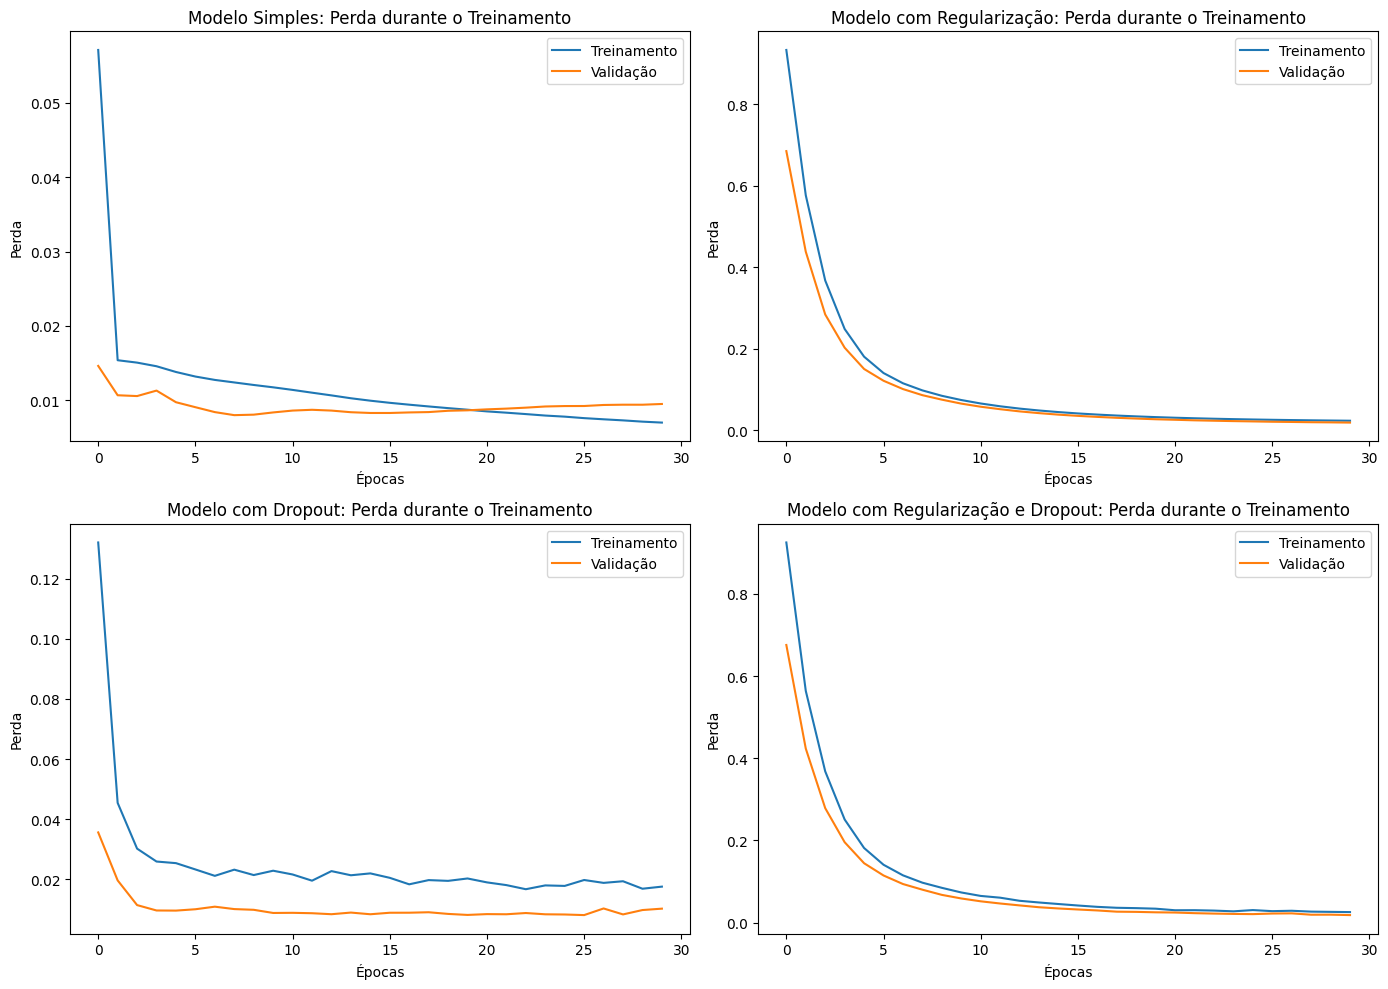

In [170]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['loss'], label='Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_cnn_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_cnn_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_cnn_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


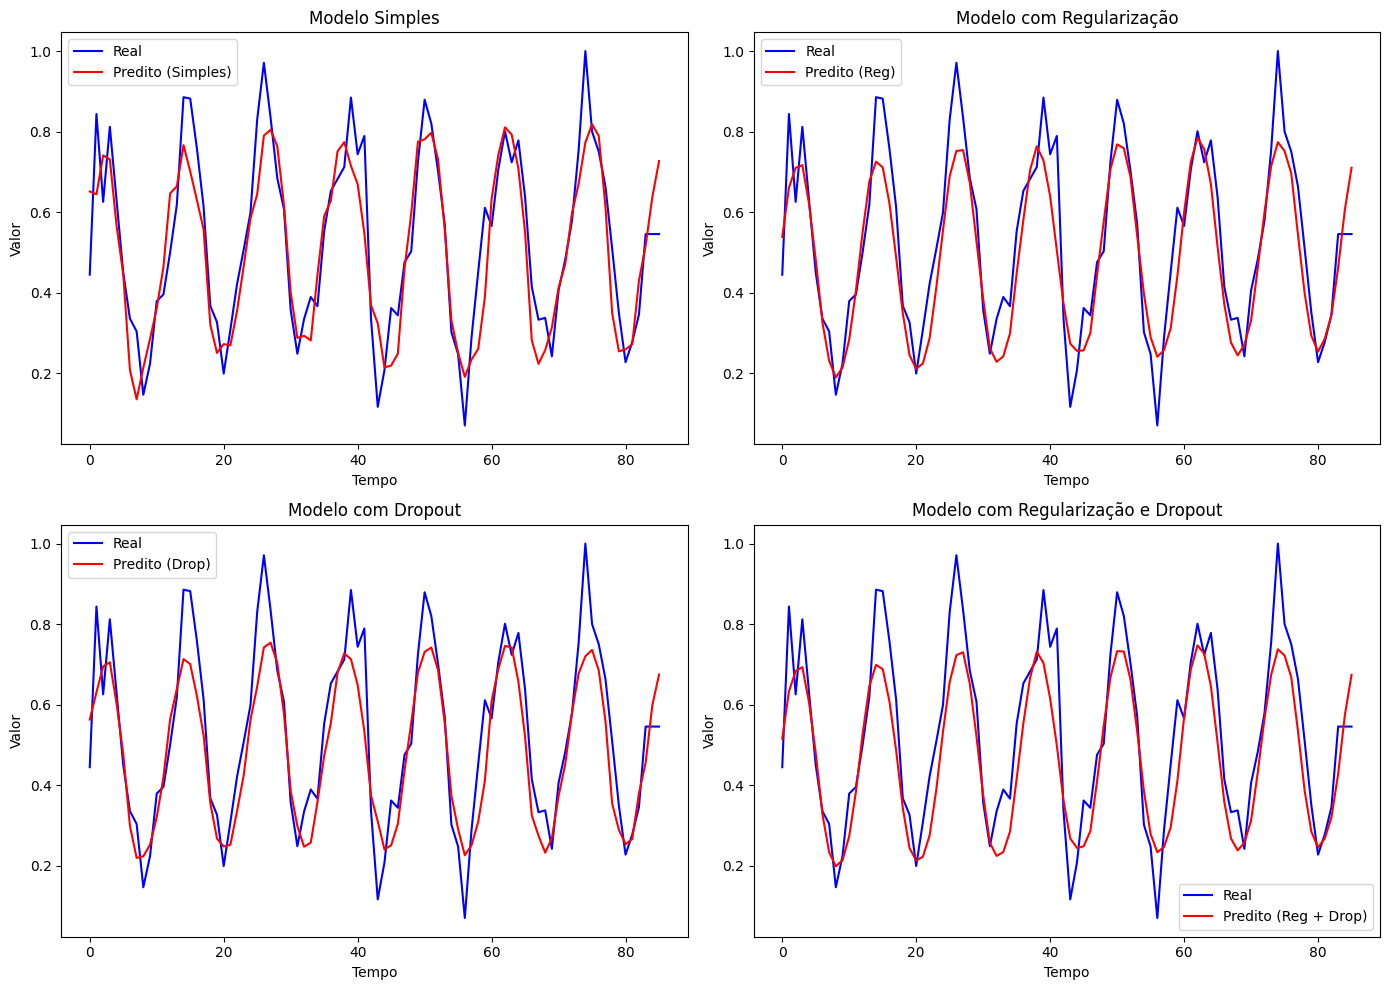

In [171]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


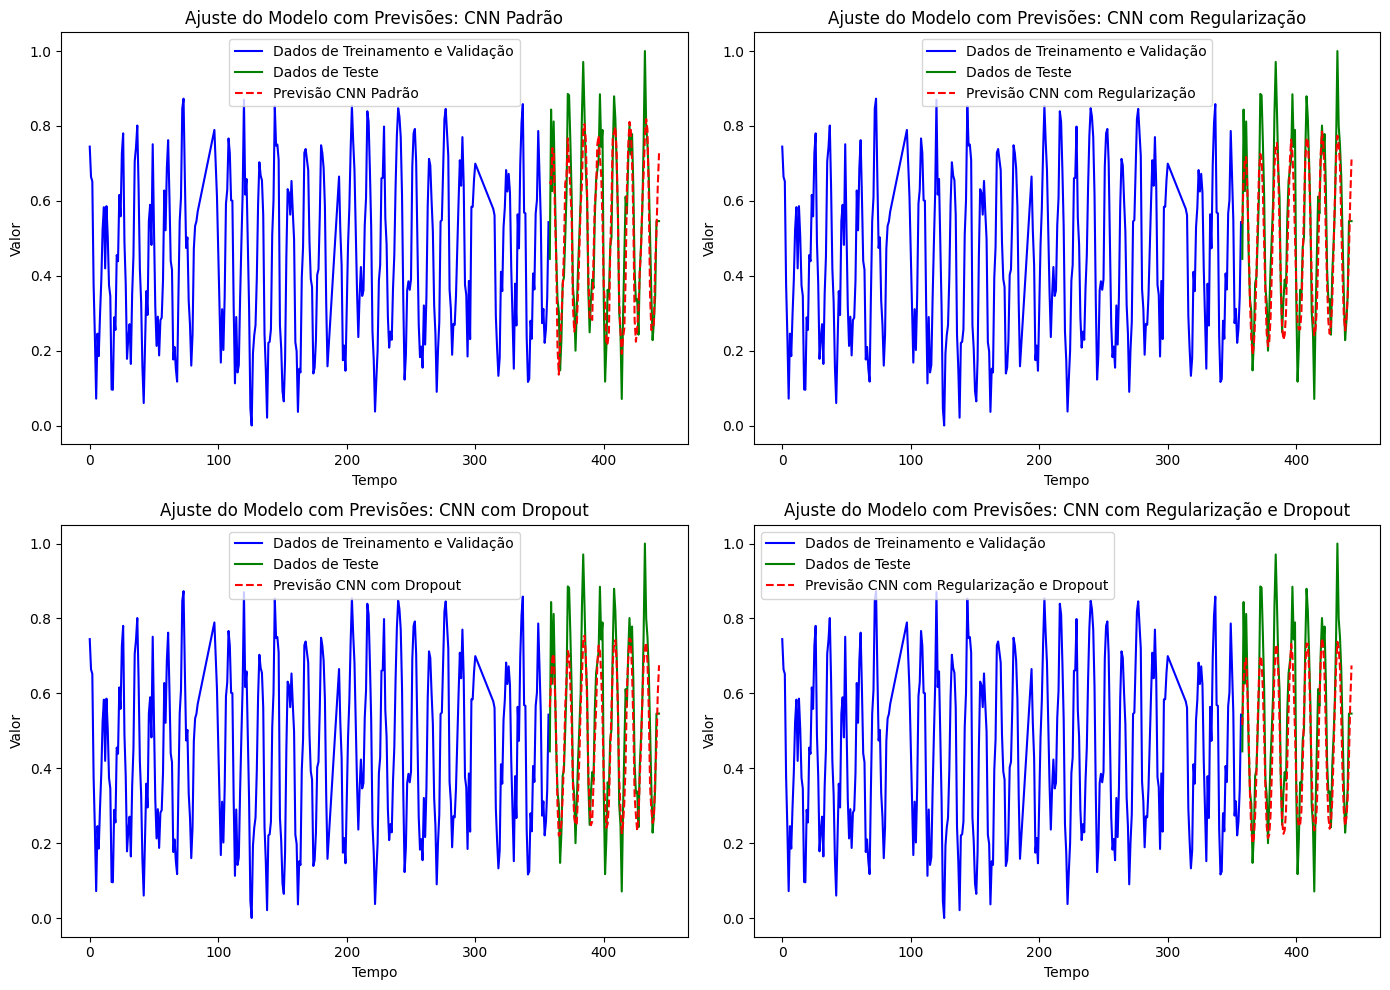

In [172]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [173]:
#Hiperparametros
epochs_lstm = 30
batch = 32
lr = 0.001
adam2 = optimizers.Adam(lr)

In [174]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Defina o comprimento da sequência
seq_length = 30  # Ajuste de acordo com sua necessidade
x_train, y_train = create_sequences(scaled_data, seq_length)


## Implementacao e Ajuste do Modelo LSTM

In [199]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam())
#model_lstm.summary()

In [200]:
history_lstm = model_lstm.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid_series, Y_valid), 
                              epochs=epochs_lstm,
                                verbose=2)

Epoch 1/30
11/11 - 4s - 337ms/step - loss: 0.2472 - val_loss: 0.1887
Epoch 2/30
11/11 - 0s - 31ms/step - loss: 0.1562 - val_loss: 0.1055
Epoch 3/30
11/11 - 0s - 31ms/step - loss: 0.0726 - val_loss: 0.0563
Epoch 4/30
11/11 - 0s - 26ms/step - loss: 0.0500 - val_loss: 0.0487
Epoch 5/30
11/11 - 0s - 28ms/step - loss: 0.0476 - val_loss: 0.0477
Epoch 6/30
11/11 - 0s - 32ms/step - loss: 0.0463 - val_loss: 0.0478
Epoch 7/30
11/11 - 0s - 38ms/step - loss: 0.0457 - val_loss: 0.0472
Epoch 8/30
11/11 - 1s - 51ms/step - loss: 0.0456 - val_loss: 0.0470
Epoch 9/30
11/11 - 0s - 32ms/step - loss: 0.0453 - val_loss: 0.0467
Epoch 10/30
11/11 - 0s - 36ms/step - loss: 0.0450 - val_loss: 0.0464
Epoch 11/30
11/11 - 0s - 35ms/step - loss: 0.0447 - val_loss: 0.0461
Epoch 12/30
11/11 - 0s - 28ms/step - loss: 0.0444 - val_loss: 0.0458
Epoch 13/30
11/11 - 0s - 29ms/step - loss: 0.0440 - val_loss: 0.0453
Epoch 14/30
11/11 - 0s - 33ms/step - loss: 0.0435 - val_loss: 0.0448
Epoch 15/30
11/11 - 0s - 30ms/step - loss:

## Implementacao e Ajuste do Modelo LSTM com Regularizacao L2

In [201]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer=optimizers.Adam(), loss='mse')
#model_lstm_reg.summary()


In [202]:
# Treinamento do modelo com regularização L2
# history_lstm_reg = model_lstm_reg.fit(X_train_series, 
#                                       y_train, 
#                                       epochs=epochs_lstm, 
#                                       batch_size=32, 
#                                       validation_split= 0.15, 
#                                       verbose=2)

history_lstm_reg = model_lstm_reg.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid_series, Y_valid), 
                              epochs=epochs_lstm,
                                verbose=2)


Epoch 1/30
11/11 - 4s - 358ms/step - loss: 0.2634 - val_loss: 0.2080
Epoch 2/30
11/11 - 1s - 79ms/step - loss: 0.1770 - val_loss: 0.1201
Epoch 3/30
11/11 - 1s - 59ms/step - loss: 0.0871 - val_loss: 0.0684
Epoch 4/30
11/11 - 0s - 31ms/step - loss: 0.0612 - val_loss: 0.0605
Epoch 5/30
11/11 - 0s - 31ms/step - loss: 0.0584 - val_loss: 0.0574
Epoch 6/30
11/11 - 1s - 55ms/step - loss: 0.0553 - val_loss: 0.0549
Epoch 7/30
11/11 - 0s - 37ms/step - loss: 0.0537 - val_loss: 0.0535
Epoch 8/30
11/11 - 0s - 45ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 9/30
11/11 - 1s - 81ms/step - loss: 0.0508 - val_loss: 0.0507
Epoch 10/30
11/11 - 0s - 44ms/step - loss: 0.0496 - val_loss: 0.0495
Epoch 11/30
11/11 - 0s - 44ms/step - loss: 0.0485 - val_loss: 0.0482
Epoch 12/30
11/11 - 0s - 33ms/step - loss: 0.0474 - val_loss: 0.0470
Epoch 13/30
11/11 - 0s - 34ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 14/30
11/11 - 0s - 31ms/step - loss: 0.0454 - val_loss: 0.0444
Epoch 15/30
11/11 - 1s - 71ms/step - loss:

## Implementacao e Ajuste do Modelo LSTM com Dropout

In [205]:
model_lstm_drop = Sequential()
model_lstm_drop.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_drop.add(Dropout(0.3))
model_lstm_drop.add(Dense(1))
model_lstm_drop.compile(optimizer=optimizers.Adam(), loss='mse')
#model_lstm_dropout.summary()


In [206]:
# Treinamento do modelo com Dropout
history_lstm_drop = model_lstm_drop.fit(X_train_series, 
                                              Y_train, 
                                              epochs=epochs_lstm, 
                                              batch_size=32, 
                                              validation_data=(X_valid_series, Y_valid), 
                                              verbose=1)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.1933 - val_loss: 0.1067
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0863 - val_loss: 0.0538
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0576 - val_loss: 0.0503
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0542 - val_loss: 0.0466
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0501 - val_loss: 0.0450
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0487 - val_loss: 0.0453
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0451 - val_loss: 0.0441
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0456 - val_loss: 0.0436
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0493 - val_loss: 0.0429
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0462 - val_loss: 0.0423
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0475 - val_loss: 0.0412
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo LSTM com Regularizacao e Dropout

In [207]:
model_lstm_reg_drop = Sequential()
model_lstm_reg_drop.add(
    LSTM(
        50, 
        activation='relu', 
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_drop.add(Dropout(0.3)) 
model_lstm_reg_drop.add(Dense(1))
model_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam())
#model_lstm_reg_dropout.summary()


In [208]:
history_lstm_reg_drop = model_lstm_reg_drop.fit(X_train_series, 
                            Y_train, 
                            epochs=epochs_lstm,
                            batch_size=32, 
                            validation_data=(X_valid_series, Y_valid),
                            verbose=2)

# history_lstm_drop = model_lstm_drop.fit(X_train_series, 
#                                               Y_train, 
#                                               epochs=epochs_lstm, 
#                                               batch_size=32, 
#                                               validation_data=(X_valid_series, Y_valid), 
#                                               verbose=1)

Epoch 1/30
11/11 - 4s - 331ms/step - loss: 0.2872 - val_loss: 0.2373
Epoch 2/30
11/11 - 0s - 26ms/step - loss: 0.2104 - val_loss: 0.1589
Epoch 3/30
11/11 - 0s - 27ms/step - loss: 0.1206 - val_loss: 0.0619
Epoch 4/30
11/11 - 0s - 26ms/step - loss: 0.0723 - val_loss: 0.0620
Epoch 5/30
11/11 - 0s - 34ms/step - loss: 0.0645 - val_loss: 0.0547
Epoch 6/30
11/11 - 0s - 30ms/step - loss: 0.0679 - val_loss: 0.0537
Epoch 7/30
11/11 - 0s - 34ms/step - loss: 0.0579 - val_loss: 0.0528
Epoch 8/30
11/11 - 1s - 56ms/step - loss: 0.0611 - val_loss: 0.0516
Epoch 9/30
11/11 - 0s - 25ms/step - loss: 0.0577 - val_loss: 0.0510
Epoch 10/30
11/11 - 0s - 35ms/step - loss: 0.0555 - val_loss: 0.0500
Epoch 11/30
11/11 - 0s - 28ms/step - loss: 0.0562 - val_loss: 0.0492
Epoch 12/30
11/11 - 0s - 36ms/step - loss: 0.0539 - val_loss: 0.0491
Epoch 13/30
11/11 - 1s - 51ms/step - loss: 0.0563 - val_loss: 0.0478
Epoch 14/30
11/11 - 0s - 26ms/step - loss: 0.0580 - val_loss: 0.0473
Epoch 15/30
11/11 - 0s - 30ms/step - loss:

## Comparativo entre os modelos - Predicao e Validacao

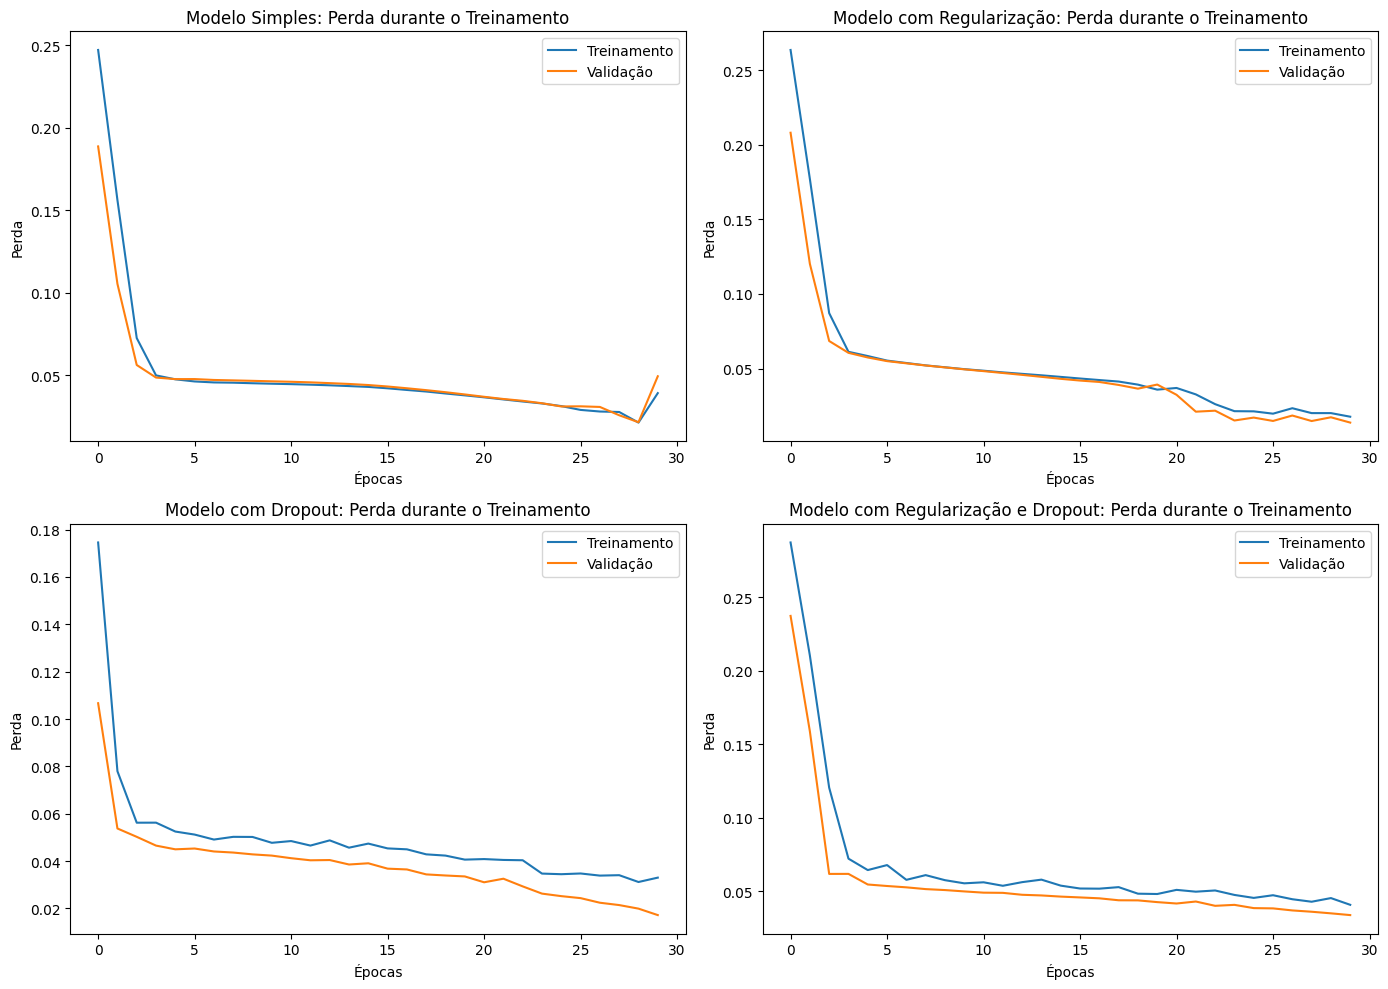

In [209]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_lstm.history['loss'], label='Treinamento')
plt.plot(history_lstm.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_lstm_reg.history['loss'], label='Treinamento')
plt.plot(history_lstm_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_lstm_drop.history['loss'], label='Treinamento')
plt.plot(history_lstm_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_lstm_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_lstm_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [184]:
# Obtendo as previsões dos quatro modelos
y_pred_lstm = model_lstm.predict(X_test_series)
y_pred_lstm_reg = model_lstm_reg.predict(X_test_series)
y_pred_lstm_drop = model_lstm_drop.predict(X_test_series)
y_pred_lstm_reg_drop = model_lstm_reg_drop.predict(X_test_series)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


In [211]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo LSTM": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_lstm),
        "MSE": mean_squared_error(Y_test, y_pred_lstm),
        "RMSE": root_mean_squared_error(Y_test, y_pred_lstm)
    },
    "Modelo LSTM com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_lstm_reg),
        "MSE": mean_squared_error(Y_test, y_pred_lstm_reg),
        "RMSE": root_mean_squared_error(Y_test, y_pred_lstm_reg)
    },
    "Modelo LSTM com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_lstm_drop),
        "MSE": mean_squared_error(Y_test, y_pred_lstm_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_lstm_drop)
    },
    "Modelo LSTM com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_lstm_reg_drop),
        "MSE": mean_squared_error(Y_test, y_pred_lstm_reg_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_lstm_reg_drop)
    }
}

# Adicionar a acurácia com base no MAPE
for model, values in metrics.items():
    values["Acurácia"] = 100 - values["MAPE"]  # Calcula a acurácia como 100 - MAPE

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}, Acurácia={values['Acurácia']:.2f}%")

Modelo LSTM: MAPE=19.28%, MSE=0.0110, RMSE=0.1051, Acurácia=80.72%
Modelo LSTM com Regularização: MAPE=18.13%, MSE=0.0094, RMSE=0.0968, Acurácia=81.87%
Modelo LSTM com Dropout: MAPE=17.75%, MSE=0.0086, RMSE=0.0930, Acurácia=82.25%
Modelo LSTM com Regularização e Dropout: MAPE=18.22%, MSE=0.0103, RMSE=0.1013, Acurácia=81.78%


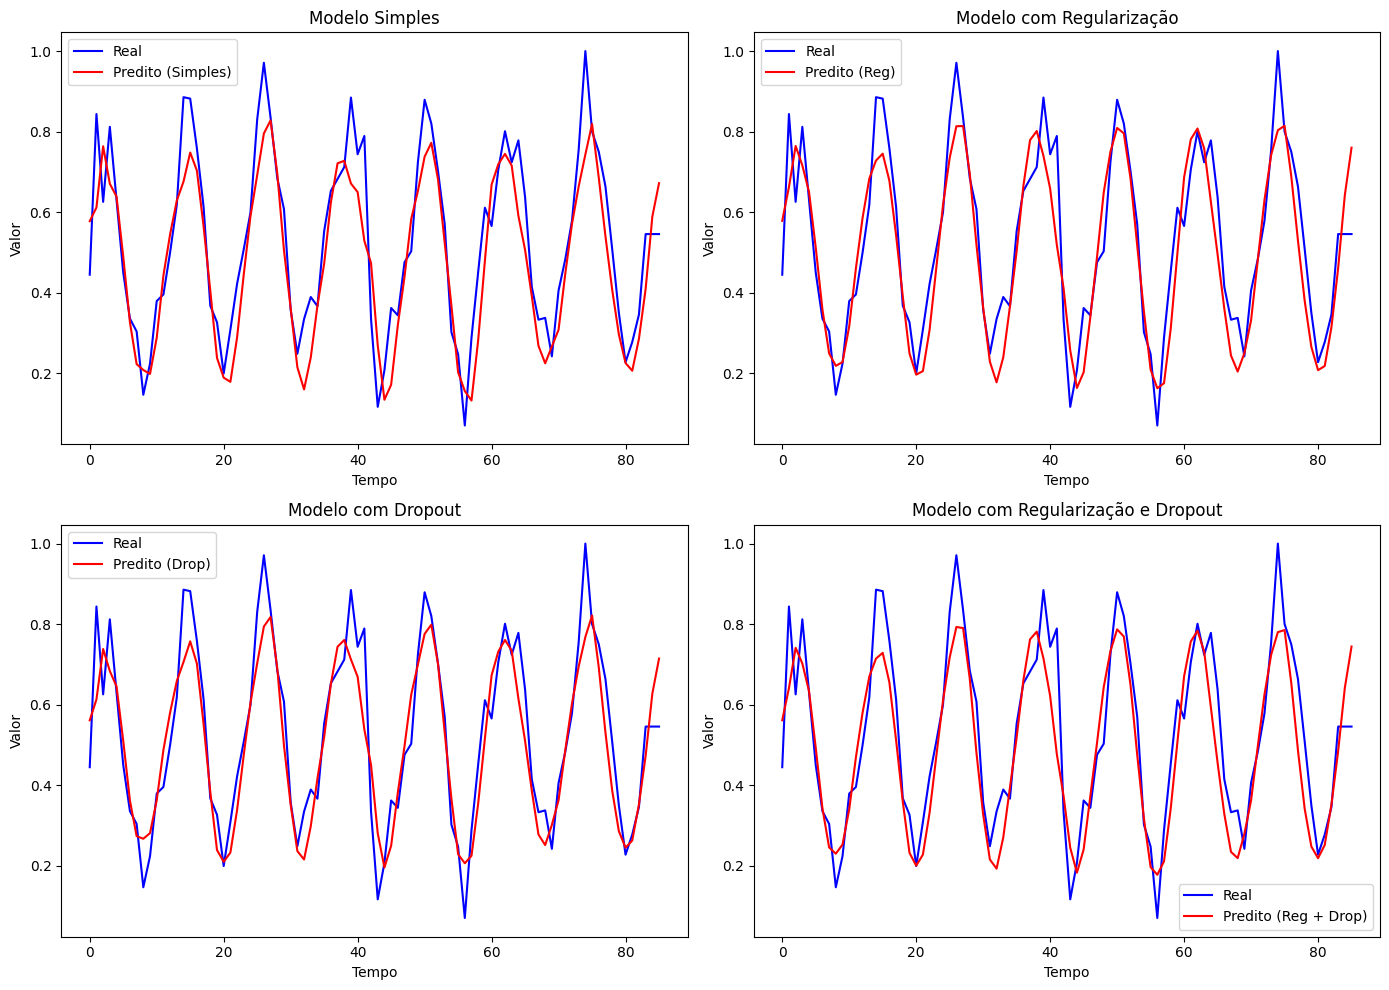

In [212]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


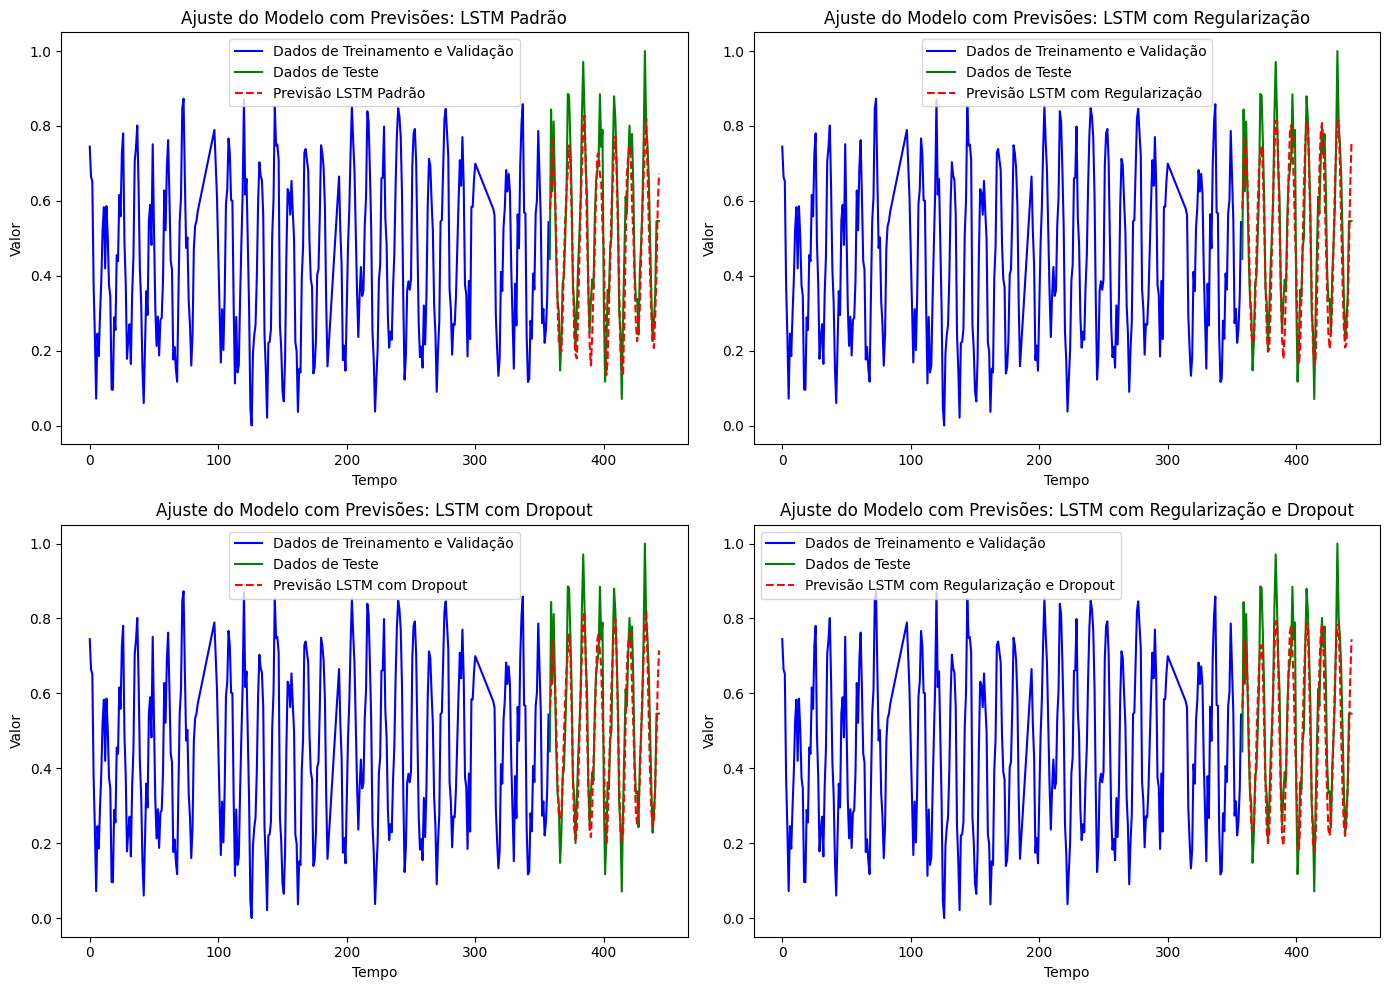

In [213]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop]
model_names = ["LSTM Padrão", "LSTM com Regularização", "LSTM com Dropout", "LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [214]:
#Hiperparametros
epochs_hibrid = 30
batch = 32
lr = 0.001

In [233]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

Train set shape (334, 2, 30, 1)
Validation set shape (24, 2, 30, 1)
Test set shape (86, 2, 30, 1)


## Implementacao e ajuste do modelo padrao

In [219]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam())

In [220]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub, 
                                      Y_train, 
                                      validation_data=(X_valid_series_sub, Y_valid), 
                                      epochs=epochs_hibrid, 
                                      verbose=2)

Epoch 1/30
11/11 - 5s - 472ms/step - loss: 0.0971 - val_loss: 0.0467
Epoch 2/30
11/11 - 1s - 59ms/step - loss: 0.0494 - val_loss: 0.0372
Epoch 3/30
11/11 - 0s - 31ms/step - loss: 0.0405 - val_loss: 0.0345
Epoch 4/30
11/11 - 0s - 35ms/step - loss: 0.0350 - val_loss: 0.0265
Epoch 5/30
11/11 - 0s - 30ms/step - loss: 0.0296 - val_loss: 0.0219
Epoch 6/30
11/11 - 0s - 37ms/step - loss: 0.0244 - val_loss: 0.0166
Epoch 7/30
11/11 - 0s - 20ms/step - loss: 0.0192 - val_loss: 0.0125
Epoch 8/30
11/11 - 0s - 19ms/step - loss: 0.0154 - val_loss: 0.0112
Epoch 9/30
11/11 - 0s - 19ms/step - loss: 0.0134 - val_loss: 0.0105
Epoch 10/30
11/11 - 0s - 38ms/step - loss: 0.0129 - val_loss: 0.0106
Epoch 11/30
11/11 - 0s - 18ms/step - loss: 0.0128 - val_loss: 0.0103
Epoch 12/30
11/11 - 0s - 35ms/step - loss: 0.0126 - val_loss: 0.0100
Epoch 13/30
11/11 - 0s - 33ms/step - loss: 0.0125 - val_loss: 0.0098
Epoch 14/30
11/11 - 0s - 35ms/step - loss: 0.0123 - val_loss: 0.0096
Epoch 15/30
11/11 - 0s - 33ms/step - loss:

## Implementacao e Ajuste do modelo com Regularizacao

In [221]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs_hibrid, verbose=2)


Epoch 1/30
11/11 - 5s - 486ms/step - loss: 0.3856 - val_loss: 0.2547
Epoch 2/30
11/11 - 1s - 62ms/step - loss: 0.2192 - val_loss: 0.1569
Epoch 3/30
11/11 - 0s - 30ms/step - loss: 0.1340 - val_loss: 0.0988
Epoch 4/30
11/11 - 0s - 19ms/step - loss: 0.0908 - val_loss: 0.0712
Epoch 5/30
11/11 - 0s - 32ms/step - loss: 0.0670 - val_loss: 0.0532
Epoch 6/30
11/11 - 0s - 22ms/step - loss: 0.0544 - val_loss: 0.0450
Epoch 7/30
11/11 - 0s - 33ms/step - loss: 0.0461 - val_loss: 0.0386
Epoch 8/30
11/11 - 0s - 28ms/step - loss: 0.0410 - val_loss: 0.0352
Epoch 9/30
11/11 - 0s - 31ms/step - loss: 0.0375 - val_loss: 0.0316
Epoch 10/30
11/11 - 0s - 32ms/step - loss: 0.0350 - val_loss: 0.0290
Epoch 11/30
11/11 - 0s - 19ms/step - loss: 0.0324 - val_loss: 0.0272
Epoch 12/30
11/11 - 0s - 33ms/step - loss: 0.0306 - val_loss: 0.0254
Epoch 13/30
11/11 - 0s - 19ms/step - loss: 0.0289 - val_loss: 0.0240
Epoch 14/30
11/11 - 0s - 33ms/step - loss: 0.0274 - val_loss: 0.0227
Epoch 15/30
11/11 - 0s - 19ms/step - loss:

## Implementacao e Ajuste do Modelo com Dropout

In [222]:
model_cnn_lstm_drop = Sequential()
model_cnn_lstm_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(LSTM(50, activation='relu'))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(Dense(1))
model_cnn_lstm_drop.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_drop = model_cnn_lstm_drop.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs_hibrid, verbose=2)


Epoch 1/30
11/11 - 5s - 415ms/step - loss: 0.0972 - val_loss: 0.0447
Epoch 2/30
11/11 - 1s - 77ms/step - loss: 0.0568 - val_loss: 0.0356
Epoch 3/30
11/11 - 0s - 19ms/step - loss: 0.0446 - val_loss: 0.0252
Epoch 4/30
11/11 - 0s - 21ms/step - loss: 0.0359 - val_loss: 0.0206
Epoch 5/30
11/11 - 0s - 32ms/step - loss: 0.0306 - val_loss: 0.0122
Epoch 6/30
11/11 - 0s - 34ms/step - loss: 0.0240 - val_loss: 0.0104
Epoch 7/30
11/11 - 0s - 20ms/step - loss: 0.0203 - val_loss: 0.0088
Epoch 8/30
11/11 - 0s - 20ms/step - loss: 0.0225 - val_loss: 0.0099
Epoch 9/30
11/11 - 0s - 31ms/step - loss: 0.0193 - val_loss: 0.0096
Epoch 10/30
11/11 - 0s - 31ms/step - loss: 0.0187 - val_loss: 0.0097
Epoch 11/30
11/11 - 0s - 23ms/step - loss: 0.0195 - val_loss: 0.0094
Epoch 12/30
11/11 - 0s - 24ms/step - loss: 0.0195 - val_loss: 0.0100
Epoch 13/30
11/11 - 0s - 28ms/step - loss: 0.0189 - val_loss: 0.0097
Epoch 14/30
11/11 - 0s - 31ms/step - loss: 0.0185 - val_loss: 0.0083
Epoch 15/30
11/11 - 0s - 20ms/step - loss:

## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [223]:
model_cnn_lstm_reg_drop = Sequential()
model_cnn_lstm_reg_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(Dense(1))
model_cnn_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs_hibrid, verbose=2)


Epoch 1/30
11/11 - 5s - 413ms/step - loss: 0.4128 - val_loss: 0.2650
Epoch 2/30
11/11 - 0s - 22ms/step - loss: 0.2386 - val_loss: 0.1696
Epoch 3/30
11/11 - 0s - 20ms/step - loss: 0.1538 - val_loss: 0.1126
Epoch 4/30
11/11 - 0s - 25ms/step - loss: 0.1129 - val_loss: 0.0829
Epoch 5/30
11/11 - 0s - 21ms/step - loss: 0.0858 - val_loss: 0.0623
Epoch 6/30
11/11 - 0s - 32ms/step - loss: 0.0683 - val_loss: 0.0526
Epoch 7/30
11/11 - 0s - 28ms/step - loss: 0.0628 - val_loss: 0.0476
Epoch 8/30
11/11 - 0s - 24ms/step - loss: 0.0553 - val_loss: 0.0430
Epoch 9/30
11/11 - 0s - 22ms/step - loss: 0.0506 - val_loss: 0.0394
Epoch 10/30
11/11 - 0s - 20ms/step - loss: 0.0483 - val_loss: 0.0357
Epoch 11/30
11/11 - 0s - 23ms/step - loss: 0.0420 - val_loss: 0.0334
Epoch 12/30
11/11 - 0s - 33ms/step - loss: 0.0431 - val_loss: 0.0318
Epoch 13/30
11/11 - 0s - 20ms/step - loss: 0.0399 - val_loss: 0.0294
Epoch 14/30
11/11 - 0s - 24ms/step - loss: 0.0396 - val_loss: 0.0280
Epoch 15/30
11/11 - 0s - 23ms/step - loss:

## Comparativo entre os modelos

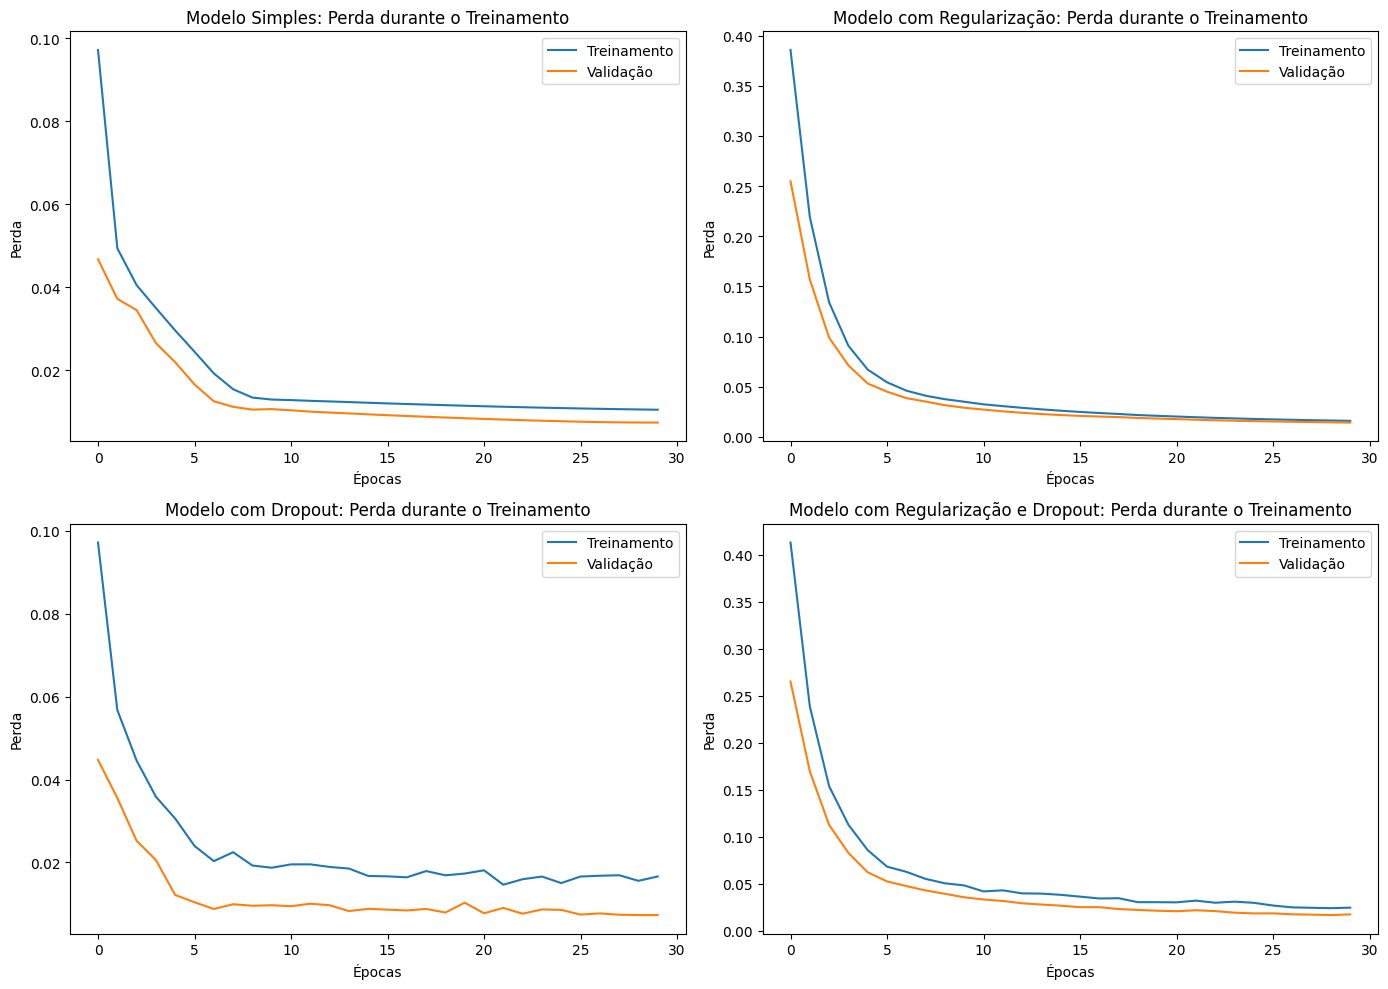

In [238]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_cnn_lstm.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_cnn_lstm_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_cnn_lstm_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_cnn_lstm_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [236]:
# Realizando previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series_sub)
y_pred_cnn_lstm_drop = model_cnn_lstm_drop.predict(X_test_series_sub)
y_pred_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.predict(X_test_series_sub)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [237]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo LSTM": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm)
    },
    "Modelo LSTM com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg)
    },
    "Modelo LSTM com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_drop),
        "MSE": mean_squared_error(Y_test, y_pred_lstm_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_lstm_drop)
    },
    "Modelo LSTM com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg_drop),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop)
    }
}

# Adicionar a acurácia com base no MAPE
for model, values in metrics.items():
    values["Acurácia"] = 100 - values["MAPE"]  # Calcula a acurácia como 100 - MAPE

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}, Acurácia={values['Acurácia']:.2f}%")

Modelo LSTM: MAPE=18.99%, MSE=0.0095, RMSE=0.0975, Acurácia=81.01%
Modelo LSTM com Regularização: MAPE=17.88%, MSE=0.0087, RMSE=0.0934, Acurácia=82.12%
Modelo LSTM com Dropout: MAPE=18.27%, MSE=0.0086, RMSE=0.0930, Acurácia=81.73%
Modelo LSTM com Regularização e Dropout: MAPE=18.64%, MSE=0.0109, RMSE=0.1043, Acurácia=81.36%


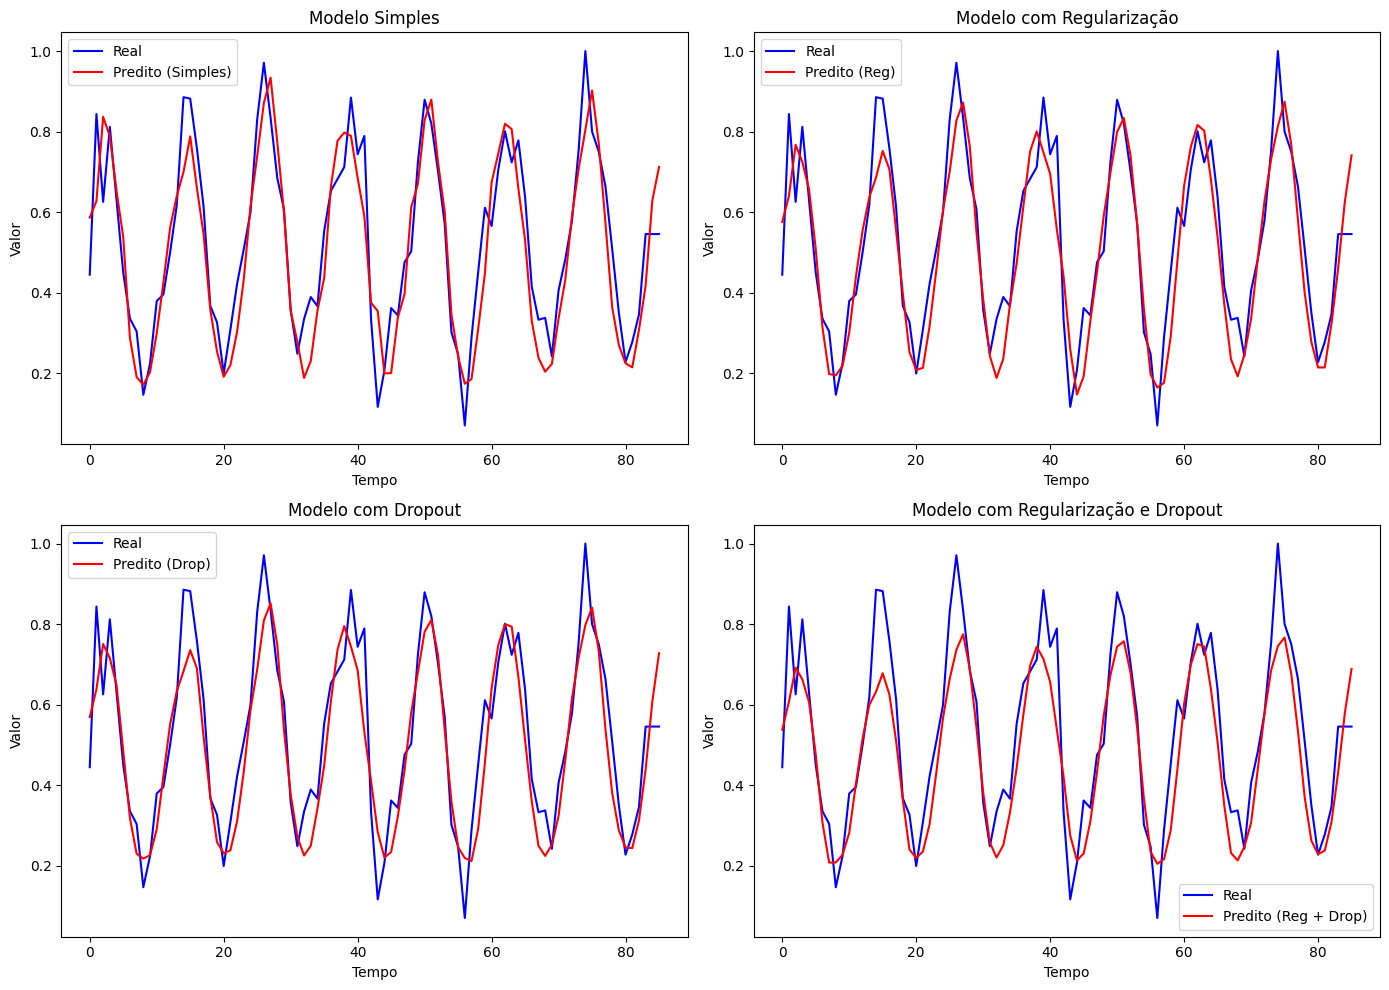

In [239]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

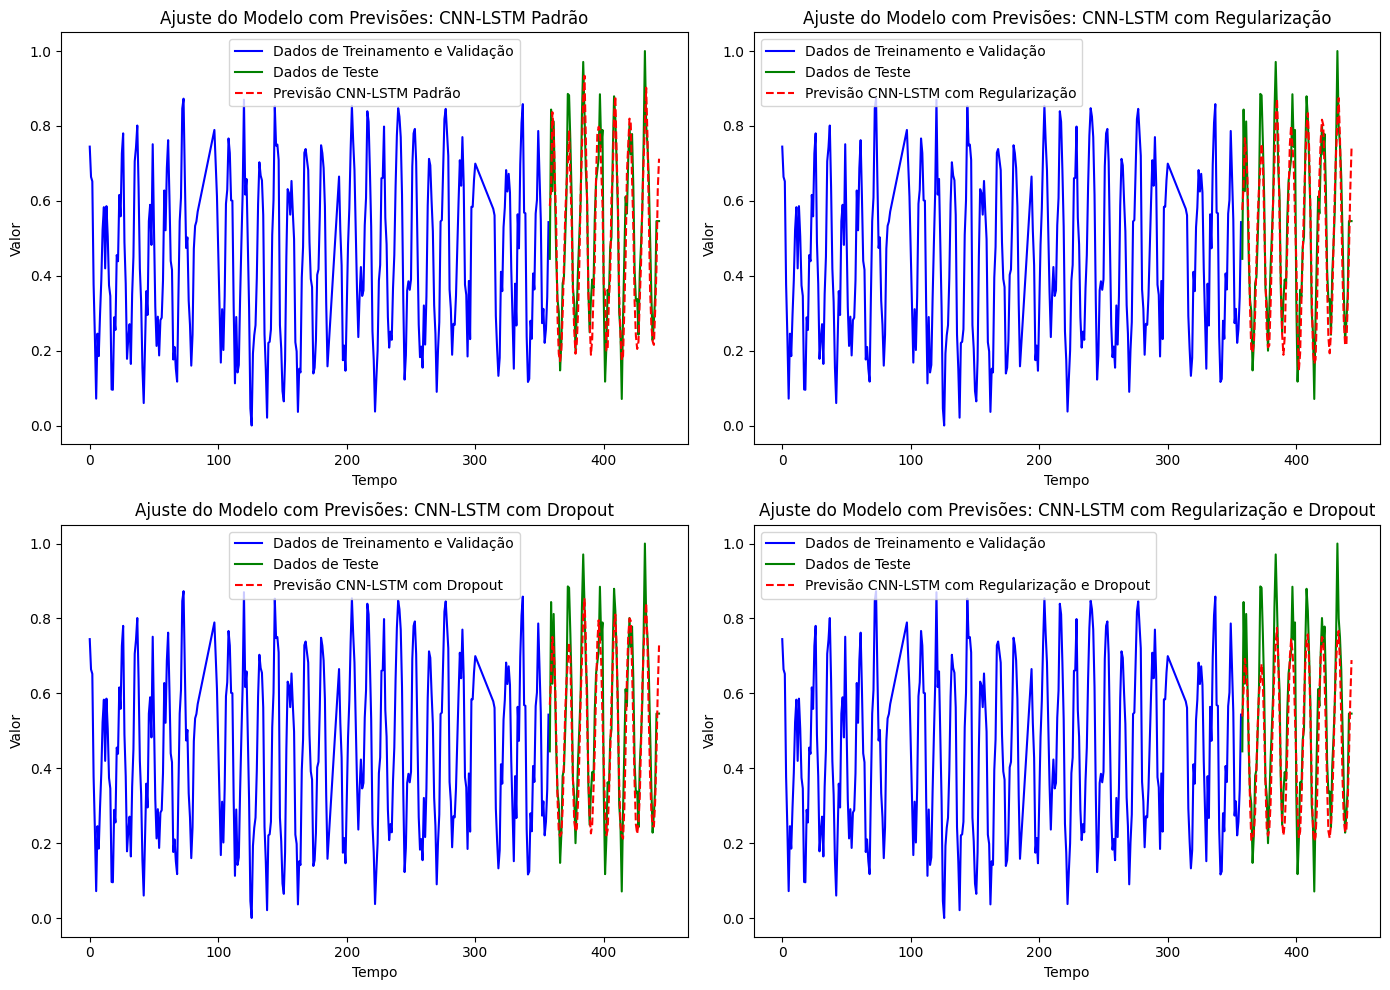

In [240]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop]
model_names = ["CNN-LSTM Padrão", "CNN-LSTM com Regularização", "CNN-LSTM com Dropout", "CNN-LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)